# Bangla Digit Recognition

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

In [3]:
from keras.models import Sequential, Model
from keras.layers import Conv2D, Dense, AveragePooling2D, Flatten, MaxPool2D, GlobalAveragePooling2D, Dropout
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.models import model_from_json

Using TensorFlow backend.
/home/arijitiiest/Desktop/Workspace/Project/Bengali-Digit_Recognition/myenv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/arijitiiest/Desktop/Workspace/Project/Bengali-Digit_Recognition/myenv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/arijitiiest/Desktop/Workspace/Project/Bengali-Digit_Recognition/myenv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, 

In [4]:
from keras import applications

### Global

In [5]:
IMG_SIZE = 32
NO_OF_CLASSES = 84

### Read Images

In [6]:
def read_images(path):
    images = []
    labels = []
    
    for file_name in os.listdir(path):
        file_path = path + '/' + file_name
        for img_name in os.listdir(file_path):
            if not img_name.startswith('.'):
                if img_name.endswith('.png'):
                    img = cv2.imread(file_path + '/' + img_name)
                    new_img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
                    image = cv2.cvtColor(new_img, cv2.COLOR_RGB2GRAY)
                    images.append(image)
                    labels.append(file_name)
    return np.array(images), np.array(labels)

### Save model:

In [7]:
def save_model(model):
    model_json = model.to_json()
    with open("models/eye_status_model.json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights("models/eye_status_model.h5")
    print("Model saved")

### Model:

### Model 1 (LeNet5):

In [24]:
def train_model1():
    model = Sequential()
    
    model.add(Conv2D(filters=32, kernel_size=(5,5), padding='same', activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1)))
    model.add(MaxPool2D(strides=2))
    
    model.add(Conv2D(filters=48, kernel_size=(5,5), padding='valid', activation='relu'))
    model.add(MaxPool2D(strides=2))
    
    model.add(Flatten())
    
    model.add(Dense(256, activation='relu'))
    
    model.add(Dense(128, activation='relu'))
    
    model.add(Dense(84, activation='softmax'))
    
    model.build()
    model.summary()
    
    return model

### model 2 ResNet:

In [36]:
def create_model2():
    base_model = applications.resnet50.ResNet50(weights= None, include_top=False, input_shape= (IMG_SIZE,IMG_SIZE,1))
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.3)(x)
    
    predictions = Dense(NO_OF_CLASSES, activation= 'softmax')(x)
    
    model = Model(inputs = base_model.input, outputs = predictions)
    
    model.build()
    model.summary()
    
    return model

## Main Cells

### Read Images:

In [7]:
full_data_x, full_data_y = read_images('BanglaLekha-Isolated/Images')

In [8]:
print("dataset size : ", full_data_x.shape, full_data_y.shape)

dataset size :  (166105, 32, 32) (166105,)


### train and validation set:

In [9]:
train_imgs, val_imgs, train_y, val_y = train_test_split(full_data_x, full_data_y, test_size=0.2)

In [10]:
print("Train data :", train_imgs.shape, "       Label: ", train_y.shape) 
print("Validation data :", val_imgs.shape, "   Label: ", val_y.shape)

Train data : (132884, 32, 32)        Label:  (132884,)
Validation data : (33221, 32, 32)    Label:  (33221,)


### Save train, validation data:

In [11]:
np.save('data/train_imgs.npy', train_imgs)
np.save('data/train_y.npy', train_y)
np.save('data/val_imgs.npy', val_imgs)
np.save('data/val_y.npy', val_y)

### Load:

In [8]:
train_imgs = np.load('data/train_imgs.npy')
train_y = np.load('data/train_y.npy')
val_imgs = np.load('data/val_imgs.npy')
val_y = np.load('data/val_y.npy')

In [9]:
train_imgs.shape, val_imgs.shape, train_y.shape, val_y.shape

((132884, 32, 32), (33221, 32, 32), (132884,), (33221,))

### Data Visualization:

65


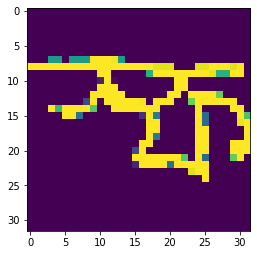

In [10]:
plt.figure(figsize=(4,10))
plt.imshow(train_imgs[0])
print(train_y[0])

### Reshape data:

In [11]:
X_train = np.reshape(train_imgs, (train_imgs.shape[0], train_imgs.shape[1], train_imgs.shape[2], 1))
X_test = np.reshape(val_imgs, (val_imgs.shape[0], val_imgs.shape[1], val_imgs.shape[2], 1))
y_train = train_y
y_test = val_y

In [12]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((132884, 32, 32, 1), (33221, 32, 32, 1), (132884,), (33221,))

In [ ]:
ohe = OneHotEncoder(sparse=False )
y_ohe = ohe.fit_transform(y_train.reshape(-1, 1))

In [23]:
# Normalize inputs
# X_dev = X_train / 255.0

In [56]:
# Data Augmentation
# datagen = ImageDataGenerator(
#             rotation_range=10, 
#             width_shift_range=0.1, 
#             height_shift_range=0.1, 
#             zoom_range=0.1)
# datagen.fit(X_dev)

### Train model:

### LeNet Model:

In [25]:
model1 = train_model1()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        832       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 48)        38448     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 6, 6, 48)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1728)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               442624    
_________________________________________________________________
dense_3 (Dense)              (None, 128)              

In [26]:
adam = Adam(lr=5e-4)
model1.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=adam)

In [30]:
model1.fit(X_train,y_ohe,batch_size=50,epochs=20,verbose=1)

Epoch 1/20
132884/132884 [==============================] - 145s 1ms/step - loss: 1.6935 - accuracy: 0.5799
Epoch 2/20
132884/132884 [==============================] - 149s 1ms/step - loss: 0.7038 - accuracy: 0.8003
Epoch 3/20
132884/132884 [==============================] - 149s 1ms/step - loss: 0.5354 - accuracy: 0.8454
Epoch 4/20
132884/132884 [==============================] - 154s 1ms/step - loss: 0.4375 - accuracy: 0.8717
Epoch 5/20
117850/132884 [=========================>....] - ETA: 17s - loss: 0.3562 - accuracy: 0.8920

KeyboardInterrupt: 

In [27]:
# Set a learning rate annealer
# reduce_lr = ReduceLROnPlateau(monitor='val_acc', 
#                                 patience=3, 
#                                 verbose=1, 
#                                 factor=0.2, 
#                                 min_lr=1e-6)

In [29]:
# model1.fit_generator(datagen.flow(X_train, y_ohe, batch_size=100), steps_per_epoch=len(X_train)/100, 
#                     epochs=10, validation_data=(X_test, y_test), callbacks=[reduce_lr])

In [ ]:
save_model(model1)

### ResNet Model:

In [33]:
model2 = create_model2()

/home/arijitiiest/Desktop/Workspace/Project/Bengali-Digit_Recognition/myenv/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [34]:
adam = Adam(lr=0.0001)
model2.compile(optimizer= adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [35]:
model2.fit(X_train, y_ohe, epochs = 20, batch_size = 64)

Epoch 1/20


KeyboardInterrupt: 

In [ ]:
save_model(model)

### Testing:

In [ ]:
predictions = model1.evaluate(X_test,y_test)
print("Loss, Accurecy ", predictions)

In [ ]:
predictions = model1.evaluate(X_test,y_test)
print("Loss, Accurecy ", predictions)